In [1]:
import pandas as pd
import importlib

import sys 
import os

os.chdir("../Feature_Design")
from author_properties_transformers import author_influence
from word2vec_transformers import conceptcluster, tokenizer
import data_preprocessor
os.chdir("../Regression")

from datetime import timezone, datetime
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load and clean data:

In [10]:
def load(subreddit):
    df_messy = pd.read_csv("../Data/subreddit_" + subreddit + "/full.csv") #, nrows = 3000)

    # This removes weekly threads, and rows that have been deleted. Also removes posts that are not text posts.
    # Creates more granular time features as well.
    df_messy = data_preprocessor.preprocess(df_messy)

    # make tokenized columns for the NLP methods
    tokenizer().in_place(X = df_messy, cols = ['title', 'selftext'])


    df = df_messy[ [  'id',  'author', 'ups', 'total_awards_received', 'num_comments', 'weektime', 'time_of_day', 'tokenized_title', 'tokenized_selftext']]
    return df


subreddit = "Jokes" # "WallStreetBets, TraditionalCurses, WritingPrompts, TwoSentenceHorror, Jokes"
df = load(subreddit)

ERROR! Session/line number was not unique in database. History logging moved to new session 662


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (20,77,82,85,112,113,114,115,116,117) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
df

,id,author,ups,total_awards_received,num_comments,weektime,time_of_day,tokenized_title,tokenized_selftext
0,eiq00s,Potential_Pandemic,2,0,1,71,23,"[[a, man, buys, a, teddy, bear, for, his, kid]]","[[the, shopkeeper, tells, him, that, this, is,..."
1,eipyw7,AkkyYT,0,0,1,71,23,"[[where, did, sallys, body, go, after, the, bo...",[[everywhere]]
2,eipwb9,speedytriple,2,0,2,71,23,"[[your, mom, is, so, dumb]]","[[she, got, hit, by, a, parked, car]]"
4,eipvg3,daytrainlane,24,0,3,71,23,"[[a, man, had, spent, all, day, drinking, in, ...","[[by, at, night, he, was, incredibly, drunk, b..."
5,eiptmq,ropumar,7,0,3,71,23,"[[what, your, girlfriend, and, santa, claus, h...","[[you, want, them, to, come], [but, do, they]]"
...,...,...,...,...,...,...,...,...,...
258024,ndcmr9,Chkgo,0,0,0,144,0,"[[theyre, remaking, scarface]]","[[theyre, remaking, scarface, but, ive, heard,..."
258025,ndcju2,cantab314,128,0,15,144,0,"[[there, are, fuckups, there, are, royal, fuck...","[[that, was, an, imperial, fuckup]]"
258026,ndch37,PremiumRedditer12,128,0,5,144,0,"[[my, uncle, jim, is, getting, older, and, hes...","[[so, he, went, to, his, doctor, and, he, star..."
258028,ndcbfd,Frostadwildhammer,6,0,2,144,0,"[[i, have, been, sending, pictures, of, my, bu...","[[so, far, no, one, has, responded, to, my, un..."


## Create feature transformers for author features, time features, and nlp features.
For details on the author and nlp transformers see, ../Feature_Design/author_properties_transformers and ../Feature_Design/word2vec_transformers

Briefly, they do the following:

1. Author influence calculates statistics of an authors upvote history from posts in the train set. 

2. Conceptcluster trains a word2vec model, then clusters the word vectors into concepts, and then counts the number of times each concept appear in the title or the selftext. Various options for the clustering approach are possible.

In [12]:
author_stat_features = FeatureUnion([('aggsum', author_influence(kind = 'sum')), 
                           ('aggmean', author_influence(kind = 'mean')), 
                           ('aggmedian', author_influence(kind = 'median')),
                            ('aggcount', author_influence(kind = 'count')),
                              #('aggpowerlaw', author_influence(kind = 'power_law')) # slows things down a lot      
                           
                           ])


In [13]:

time_features = make_union( make_column_transformer(  
                                (FunctionTransformer(lambda x : x), ["weektime", "time_of_day"] ),
                                                   )            
                          )


In [14]:
nlp_features = make_union( conceptcluster(verbose = False) )

In [15]:
# other features -- whether score >= 100
# predictors for whether different kinds of awards were given


In [16]:


all_features = make_union ( author_stat_features, time_features, nlp_features )

## Run a regression experiment:

Trying to predict upvotes using those features. No luck so far. 

Comments: xgboost overfits, linear regression underfits.
 

working on LinearRegression()


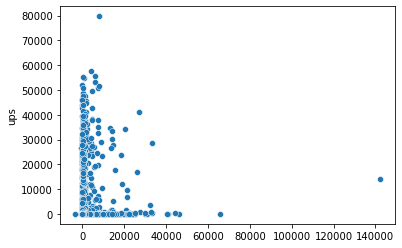

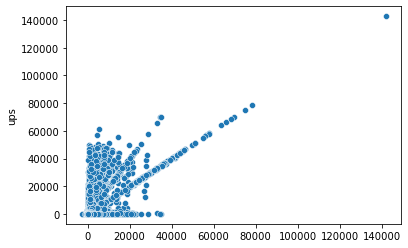

[-0.07434101 -0.06811012 -0.08467393 -0.05573427 -0.22686577]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


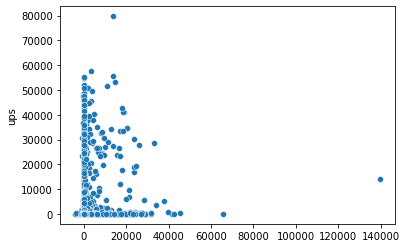

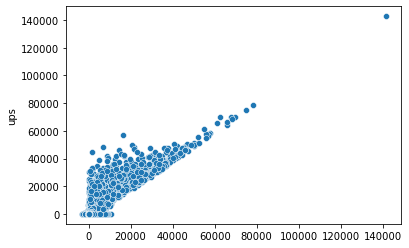

[-0.11217858 -0.09019991 -0.12574189 -0.07889922 -0.29367995]


In [17]:
def run_experiment(model, X, y):
    

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline(all_features, model)
    # all features drops the 'ups' category.
    
    pipe.fit(X_train, y_train)

    pipe.predict(X_test)

    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe, X, y)
    print(scores)
    
    return pipe

pipes = []
for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    X = df.drop(columns=['total_awards_received', 'num_comments'])
    y = df.ups
    pipes.append(run_experiment(model, X, y))


In [19]:
cc = pipes[0]['featureunion'].get_params()['featureunion-3'].get_params()['conceptcluster']

In [30]:
cc.corpus_df.prediction.value_counts().head(25)

56    6188
41    2254
6     1040
2      842
14     406
33     357
12     329
52     207
20     180
60     165
31     162
47     153
37     153
0      108
26      93
59      81
21      79
28      71
3       58
11      55
18      53
7       53
64      50
43      47
4       39
Name: prediction, dtype: int64

In [31]:
cc.corpus_df[ cc.corpus_df.prediction == 4]

,vector,prediction
word,,
at,"[1.6619686, -0.3810158, 1.2909695, -0.91017896...",4
there,"[-0.21183588, 0.65632164, 0.9058278, 0.2620722...",4
having,"[0.33535612, 0.3232114, -0.77476096, -0.928328...",4
getting,"[0.18164812, -0.08888113, -0.120902434, -0.776...",4
doing,"[0.08241607, 0.4445803, 0.67840654, -0.6433735...",4
looking,"[-0.30266705, 0.7554227, 0.13321874, -0.968093...",4
walking,"[0.109597914, 0.6154606, 1.4373881, 0.93235666...",4
sitting,"[0.8340582, 1.1354213, -0.1267038, 0.3486978, ...",4
talking,"[-0.26959273, 0.49037638, -0.11291931, 1.03295...",4
